In [1]:
import sys
import warnings
import os
if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from copy import deepcopy as copy
from torch.utils.data import DataLoader, TensorDataset
sns.set()
def seed_torch(seed=1122):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_torch()

# Loading the data

In [3]:
sh02 = pd.read_csv('history_sh.000002_stock_k_data.csv')
sh02

,date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST
0,2016-01-04,sh.000002,3701.5840,3703.7780,3449.4990,3450.0310,3704.2950,18281590784,2.396183e+11,3,0.006706,1,-6.864000,NaN
1,2016-01-05,sh.000002,3345.6250,3483.1210,3338.1000,3440.7850,3450.0310,26481264384,3.267413e+11,3,0.009714,1,-0.268000,NaN
2,2016-01-06,sh.000002,3444.4410,3519.7290,3442.2000,3518.5410,3440.7850,23725938688,2.840042e+11,3,0.008703,1,2.259800,NaN
3,2016-01-07,sh.000002,3463.8910,3463.8910,3261.1640,3270.7060,3518.5410,7008106496,7.959070e+10,3,0.002568,1,-7.043700,NaN
4,2016-01-08,sh.000002,3343.4420,3386.2810,3199.2530,3334.9340,3270.7060,28444573440,3.225776e+11,3,0.010407,1,1.963700,NaN
5,2016-01-11,sh.000002,3277.7800,3313.9080,3157.7010,3157.7120,3334.9340,26944272384,2.847142e+11,3,0.009854,1,-5.314100,NaN
6,2016-01-12,sh.000002,3167.6260,3190.0330,3117.5800,3164.0670,3157.7120,20644969472,2.232045e+11,3,0.007549,1,0.201300,NaN
7,2016-01-13,sh.000002,3183.0890,3201.7530,3086.8800,3087.2040,3164.0670,19306988288,2.073971e+11,3,0.007060,1,-2.429200,NaN
8,2016-01-14,sh.000002,3008.1150,3152.6980,3001.3570,3147.8630,3087.2040,21155713536,2.169661e+11,3,0.007736,1,1.964900,NaN
9,2016-01-15,sh.000002,3127.3020,3141.6150,3018.1250,3036.0450,3147.8630,19748977408,2.056726e+11,3,0.007222,1,-3.552200,NaN


In [4]:
sh02.drop(['code','preclose','amount','adjustflag','turn','tradestatus','pctChg','isST'], axis=1, inplace=True)

In [5]:
sh02.head()

,date,open,high,low,close,volume
0,2016-01-04,3701.584,3703.778,3449.499,3450.031,18281590784
1,2016-01-05,3345.625,3483.121,3338.100,3440.785,26481264384
2,2016-01-06,3444.441,3519.729,3442.200,3518.541,23725938688
3,2016-01-07,3463.891,3463.891,3261.164,3270.706,7008106496
4,2016-01-08,3343.442,3386.281,3199.253,3334.934,28444573440


In [6]:
class GetData:
    def __init__(self):
        self.data = sh02.set_index('date')
        
    def getData(self):
        self.close_min = self.data['close'].min()
        self.close_max = self.data["close"].max()
        self.data = self.data.apply(lambda x: (x - min(x)) / (max(x) - min(x)))
        return self.data
    
    def process_data(self, n):
        self.getData()
        feature = [
            self.data.iloc[i: i + n].values.tolist()
            for i in range(len(self.data) - n + 2)
            if i + n < len(self.data)
        ]
        label = [
            self.data.close.values[i + n]
            for i in range(len(self.data) - n + 2)
            if i + n < len(self.data)
        ]
        num = int(len(feature) * 0.9)
        train_x = feature[:num]
        test_x = feature[num:]
        train_y = label[:num]
        test_y = label[num:]
        return train_x, test_x, train_y, test_y

In [7]:
class Model(nn.Module):
    def __init__(self, n):
        super(Model, self).__init__()
        self.lstm_layer = nn.LSTM(input_size=n, hidden_size=128, batch_first=True)
        self.linear_layer = nn.Linear(in_features=128, out_features=1, bias=True)
    def forward(self, x):
        out1, (h_n, h_c) = self.lstm_layer(x)
        a, b, c = h_n.shape
        out2 = self.linear_layer(h_n.reshape(a*b, c))
        return out2

In [8]:
GD = GetData()

In [9]:
train_x, test_x, train_y, test_y = GD.process_data(5)
train_x

[[[0.8512823399182955,
   0.8406517704461433,
   0.695626825107643,
   0.6719463765157253,
   0.1921013025923221],
  [0.5855685411177136,
   0.6717255399094605,
   0.6089137060500067,
   0.6648019154511835,
   0.33182456286852213],
  [0.6593320215811329,
   0.6997511699483301,
   0.689945274501249,
   0.7248846230582034,
   0.28487353674866417],
  [0.6738509223159685,
   0.6570038160882338,
   0.5490266287170119,
   0.5333804582376658,
   0.0],
  [0.5839389904594028,
   0.5975886842231581,
   0.5008350299236894,
   0.5830099677826998,
   0.3652795460320115]],
 [[0.5855685411177136,
   0.6717255399094605,
   0.6089137060500067,
   0.6648019154511835,
   0.33182456286852213],
  [0.6593320215811329,
   0.6997511699483301,
   0.689945274501249,
   0.7248846230582034,
   0.28487353674866417],
  [0.6738509223159685,
   0.6570038160882338,
   0.5490266287170119,
   0.5333804582376658,
   0.0],
  [0.5839389904594028,
   0.5975886842231581,
   0.5008350299236894,
   0.5830099677826998,
   0.365

In [10]:
train_y

[0.44606905508745753,
 0.45097961641832085,
 0.391586937335056,
 0.4384586509100108,
 0.3520559527362144,
 0.3624465614248249,
 0.43835278987109233,
 0.4133247676041112,
 0.3355686754558633,
 0.36474536865681834,
 0.38248288798804847,
 0.22969913674572678,
 0.21814946558720358,
 0.15342123560077386,
 0.21970106388025987,
 0.18023189594648056,
 0.22932205508884831,
 0.22093585176487382,
 0.25472020463788814,
 0.24045910000808252,
 0.22651171495346695,
 0.2997335547194165,
 0.32463021657314084,
 0.3209528977102646,
 0.31863786360369223,
 0.37301180219223534,
 0.3536886854021646,
 0.37437408694853935,
 0.22258635672202942,
 0.2435321609699779,
 0.17955577617236484,
 0.216097925015458,
 0.31036370298514226,
 0.31857218339706384,
 0.33037453017402785,
 0.34907948031347874,
 0.3523511273118855,
 0.3209675791682166,
 0.2740587755942244,
 0.27856521047724475,
 0.31831332611211666,
 0.32228272871741104,
 0.32731228712851873,
 0.3550950145323254,
 0.3957510624352953,
 0.44727757088941966,
 0.431

In [11]:
print(len(train_x))
print(len(train_x[0]))
print(len(test_x))
print(len(test_x[0]))
print(len(train_y))
print(len(test_y))

1143
5
127
5
1143
127


# 训练与测试
1. 计算损失loss
2. 损失 backward
3. 优化器 step
（不要忘记优化器清零梯度）

In [22]:
def train_model(epoch, train_dataLoader, test_dataLoader):
    # 训练模型
    best_model = None
    train_loss = 0
    test_loss = 0
    best_loss = 100
    epoch_cnt = 0
    for _ in range(epoch):
        total_train_loss = 0
        total_train_num = 0
        total_test_loss = 0
        total_test_num = 0
        for x, y in tqdm(train_dataLoader,
                         desc='Epoch: {}| Train Loss: {}| Test Loss: {}'.format(_, train_loss, test_loss)):
            x_num = len(x)
            p = model(x)
            # print(len(p[0]))
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_num += x_num
        train_loss = total_train_loss / total_train_num
        for x, y in test_dataLoader:
            x_num = len(x)
            p = model(x)
            loss = loss_func(p, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_test_loss += loss.item()
            total_test_num += x_num
        test_loss = total_test_loss / total_test_num
        
        # early stop
        if best_loss > test_loss:
            best_loss = test_loss
            best_model = copy(model)
            torch.save(best_model.state_dict(), 'lstm_.pth')
            epoch_cnt = 0
        else:
            epoch_cnt += 1
            
        if epoch_cnt > early_stop:
            torch.save(best_model.state_dict(), 'lstm_.pth')
            print("保存模型")
            print(best_model.state_dict())
            break

In [13]:
def test_model(test_dataLoader_):
    pred = []
    label = []
    model_ = Model(5)
    model_.load_state_dict(torch.load("lstm_.pth"))
    model_.eval()
    total_test_loss = 0
    total_test_num = 0
    for x, y in test_dataLoader_:
        x_num = len(x)
        p = model_(x)
        print('##', len(p), len(y))
        loss = loss_func(p, y)
        total_test_loss += loss.item()
        total_test_num += x_num
        pred.extend(p.data.squeeze(1).tolist())
        label.extend(y.tolist())
    test_loss = total_test_loss / total_test_num
    # print('##', len(pred), len(label))
    return pred, label, test_loss

In [14]:
def plot_img(data, pred):
    # plt.figure(figsize=(18, 9))
    plt.plot(range(len(pred)), pred, color='green')
    # plt.plot(range(len(data)), data)
    plt.plot(range(len(data)), data, color='b')
    for i in range(0, len(pred)-3, 5):
        price = [data[i]+pred[j]-pred[i] for j in range(i, i+3)]
        plt.plot(range(i, i+3), price, color='r')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close', fontsize=18)
    plt.show()

Epoch: 0| Train Loss: 0| Test Loss: 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 274.88it/s]
Epoch: 1| Train Loss: 0.0016464748380506902| Test Loss: 0.0005558702446644994: 100%|█████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 263.64it/s]
Epoch: 2| Train Loss: 0.000954205464876859| Test Loss: 0.0006556825484992482: 100%|██████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 267.28it/s]
Epoch: 3| Train Loss: 0.0008874444078331388| Test Loss: 0.0005410007333133634: 100%|█████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 260.09it/s]
Epoch: 4| Train Loss: 0.0005661680563051524| Test Loss: 0.0003867672745314405: 100%|█████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:0

## 20 20
## 20 20
## 20 20
## 20 20
## 20 20
## 20 20
## 7 7
127 127


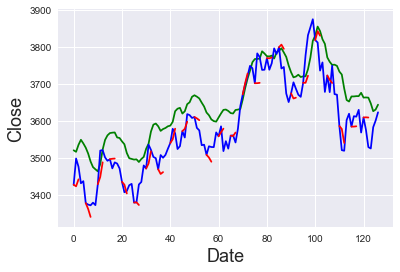

0.0003249895773593366


In [23]:
if __name__ == '__main__':
    # 参数
    days_num = 5
    epoch = 20
    fea = 5
    batch_size = 20
    early_stop = 5
    
    # 初始化模型
    model = Model(fea)
    
    # 数据处理部分
    GD = GetData()
    x_train, x_test, y_train, y_test = GD.process_data(days_num)
    # print(x_train)
    x_train = torch.tensor(x_train).float()
    x_test = torch.tensor(x_test).float()
    y_train = torch.tensor(y_train).float()
    y_test = torch.tensor(y_test).float()
    train_data = TensorDataset(x_train, y_train)
    train_dataLoader = DataLoader(train_data, batch_size=batch_size)
    test_data = TensorDataset(x_test, y_test)
    test_dataLoader = DataLoader(test_data, batch_size=batch_size)
    
    # 损失函数和优化器
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    train_model(epoch, train_dataLoader, test_dataLoader)
    p, y, test_loss = test_model(test_dataLoader)
    print(len(p), len(y))
    
    # 画图
    pred = [ele * (GD.close_max - GD.close_min) + GD.close_min for ele in p]
    data = [ele * (GD.close_max - GD.close_min) + GD.close_min for ele in y]
    plot_img(data, pred)
    print(test_loss)